In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from seispy.station.stationdata import SeismometerArray
from seispy.station import homestake
from scipy.linalg import pinv2,svd
from numpy.linalg import inv
plt.style.use('stylesheet.mplstyle')
from scipy.io import savemat
import astropy.units as u
import numpy as np
import os
os.environ['PROJ_LIB'] = '/home/patrick.meyers/anaconda3/envs/meyers/share/proj'
import seispy.plot as hplot
import healpy as hp
from matplotlib import colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [2]:
from seispy.trace import Trace, fetch
from gwpy.time import tconvert

In [3]:
norm = np.sum(np.hanning(128 * 100)**2) * (2 * np.pi * 0.2)**2 * 128
print(norm**-1)

1.03077290831e-06


In [70]:
st = tconvert('October 2 2015')
et = tconvert('October 3 2015 12:00:00')

In [71]:
dataHHZ = fetch(st, et, 'YATES:HHZ', framedir='/archive/frames/homestake/')
dataHHE = fetch(st, et, 'YATES:HHE', framedir='/archive/frames/homestake/')
specgram = dataHHZ.csd_spectrogram(dataHHE, stride=100., window='hann')
ang = np.angle(specgram)
amp = np.abs(specgram)
print(np.max(amp.flatten()))
print(np.min(amp.flatten()))
ang = ang.crop_frequencies(1, 2.5)
amp = amp.crop_frequencies(1, 2.5)

6.733369325003894e-12 1 / Hz
4.256078814634766e-25 1 / Hz


/home/patrick.meyers/anaconda3/envs/meyers/lib/python3.8/site-packages/gwpy/plot/axes.py:281: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return super(Axes, self).pcolormesh(*args, **kwargs)


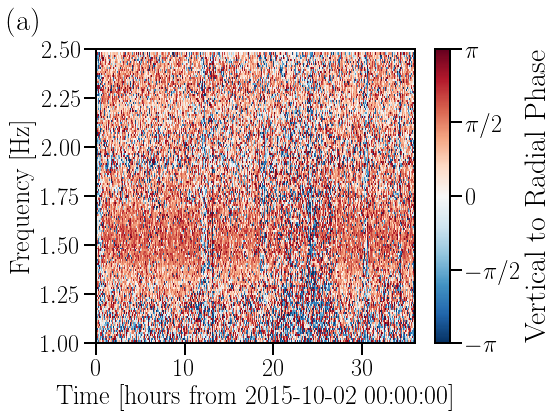

In [80]:
plt.figure(figsize=(8,6))
plt.pcolormesh((ang.times.value - ang.times.value[0]) / 3600, ang.frequencies.value, ang.T, cmap='RdBu_r', vmin=-np.pi, vmax=np.pi)#,
#              norm= MidpointNormalize(vmin=-np.pi, vcenter=np.pi/2., vmax=np.pi))
plt.ylim(1, 2.5)
h = plt.colorbar()
ticks = [-np.pi, -np.pi/2., 0, np.pi/2., np.pi]
ticklabels = ['$-\\pi$', '$-\\pi/2$', '0', '$\\pi/2$','$\\pi$' ]
h.set_ticks(ticks)
h.set_ticklabels(ticklabels)
h.ax.tick_params(labelsize=24)
h.ax.set_ylabel('Vertical to Radial Phase', fontsize=30)
ax = plt.gca()
plt.ylabel('Frequency [Hz]')
ax.tick_params(labelsize=24)
plt.text(-10, 2.6, '(a)', fontsize=30)
plt.xlabel(f'Time [hours from {tconvert(dataHHZ.times.value[0])}]')
plt.tight_layout()
plt.savefig('phase_plot_1_6_Hz')

plt.show()

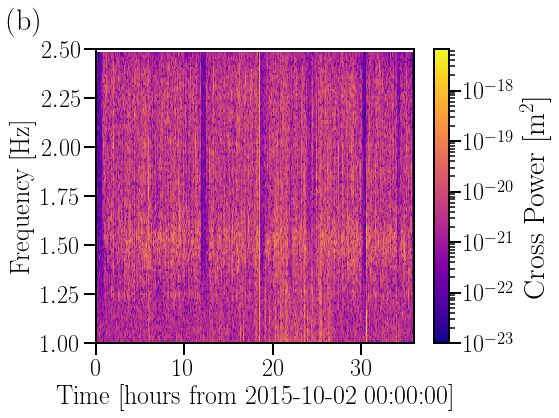

In [81]:
plt.figure(figsize=(8,6))
plt.pcolormesh((amp.times.value - amp.times.value[0]) / 3600, amp.frequencies.value, (amp.value / 100 / (2 * np.pi * amp.frequencies.value)**2).T, cmap='plasma',
             norm=colors.LogNorm(vmin=1e-23))
plt.ylim(1, 2.5)
h = plt.colorbar()
# ticks = [-np.pi, -np.pi/2., 0, np.pi/2., np.pi]
# ticklabels = ['$-\\pi$', '$-\\pi/2$', '0', '$\\pi/2$','$\\pi$' ]
# h.set_ticks(ticks)
# h.set_ticklabels(ticklabels)
h.ax.tick_params(labelsize=24)
h.ax.set_ylabel('Cross Power $\\rm{[m^2]}$', fontsize=30)
plt.ylabel('Frequency [Hz]')
ax = plt.gca()
ax.tick_params(labelsize=24)
plt.xlabel(f'Time [hours from {tconvert(dataHHZ.times.value[0])}]')
plt.text(-10, 2.6, '(b)', fontsize=30)
plt.tight_layout()
plt.savefig('amp_plot_1_6_Hz')
plt.show()

In [8]:
bins = np.linspace(-np.pi, np.pi, num=80)
ang.crop_frequencies(1, 2.5)
hists = np.zeros((ang.frequencies.size, bins.size - 1))
for ii in range(ang.frequencies.value.size):
    hists[ii, :], xedges = np.histogram(ang.value[:, ii], bins=bins)


/home/patrick.meyers/anaconda3/envs/meyers/lib/python3.8/site-packages/gwpy/spectrogram/spectrogram.py:576: UserWarning: Spectrogram.crop_frequencies given high frequency cutoff above cutoff of the input Spectrogram. High frequency crop will have no effect.
  warnings.warn('Spectrogram.crop_frequencies given high frequency '


/home/patrick.meyers/anaconda3/envs/meyers/lib/python3.8/site-packages/gwpy/plot/axes.py:281: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return super(Axes, self).pcolormesh(*args, **kwargs)


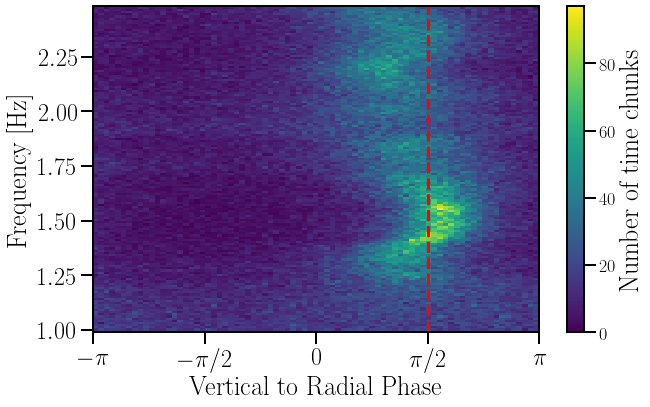

In [10]:
bincs = (bins[1:] + bins[:-1])/2.
plt.pcolormesh(bins, ang.frequencies.value, hists)
h = plt.colorbar()
h.ax.set_ylabel('Number of time chunks')
ax = plt.gca()
ax.axvline(np.pi/2., c='r', ls='--')
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.tick_params(labelsize=24)
plt.xlabel('Vertical to Radial Phase')
plt.ylabel('Frequency [Hz]')

plt.show()